In [1]:
! pip install fredapi 
!pip install nbimporter

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat

plt.style.use('fivethirtyeight')
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]


In [3]:
# Import API key from other notebook
def load_secrets(notebook_path):
    with open(notebook_path, "r", encoding="utf-8") as f:
        notebook = nbformat.read(f, as_version=4)
        global_vars = {}
        for cell in notebook['cells']:
            if cell['cell_type'] == 'code':  
                try:
                    exec(cell['source'], global_vars)
                except Exception as e:
                    print(f"Error executing cell: {e}")
        return global_vars

# Load the secrets notebook
secrets = load_secrets("secrets.ipynb") 

# Access the API key
fred_key = secrets.get("MyFREDAPI")

In [4]:
from fredapi import Fred
fred = Fred(api_key = fred_key)


# Pull Raw Data

<Axes: title={'center': 'Unemployment Rate'}>

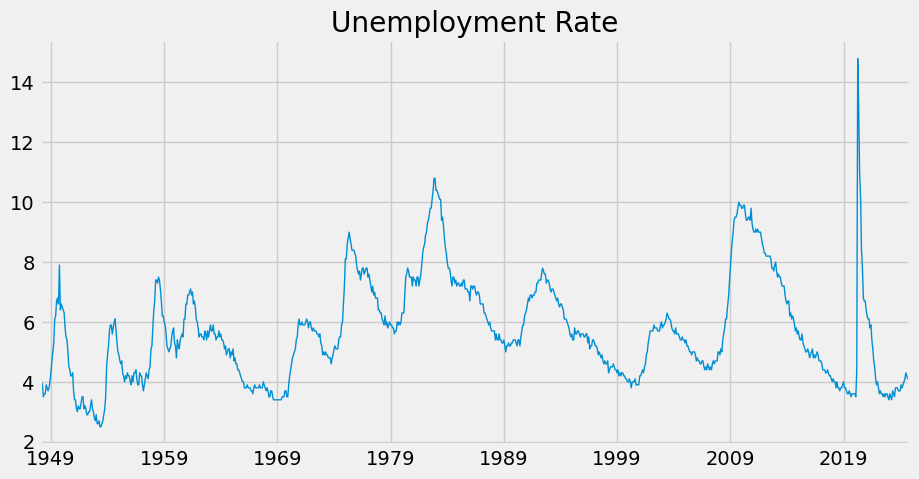

In [5]:
unrate_search = fred.search('Unemployment', order_by = 'popularity')
unrate = fred.get_series(series_id = 'UNRATE')
unrate.plot(figsize=(10,5),title = 'Unemployment Rate',lw=1)

In [6]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [7]:
import time
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(1) 

uemp_results = pd.concat(all_results, axis=1)

In [8]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [9]:
uemp_states = uemp_results.copy() 
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

## Unemployment Rate by States

In [10]:
# Plot States Unemployment Rate
plot = px.line(uemp_states,title = "Unemployment Rate by States")
plot.show()

# Unemployment Rate By State, May 2020

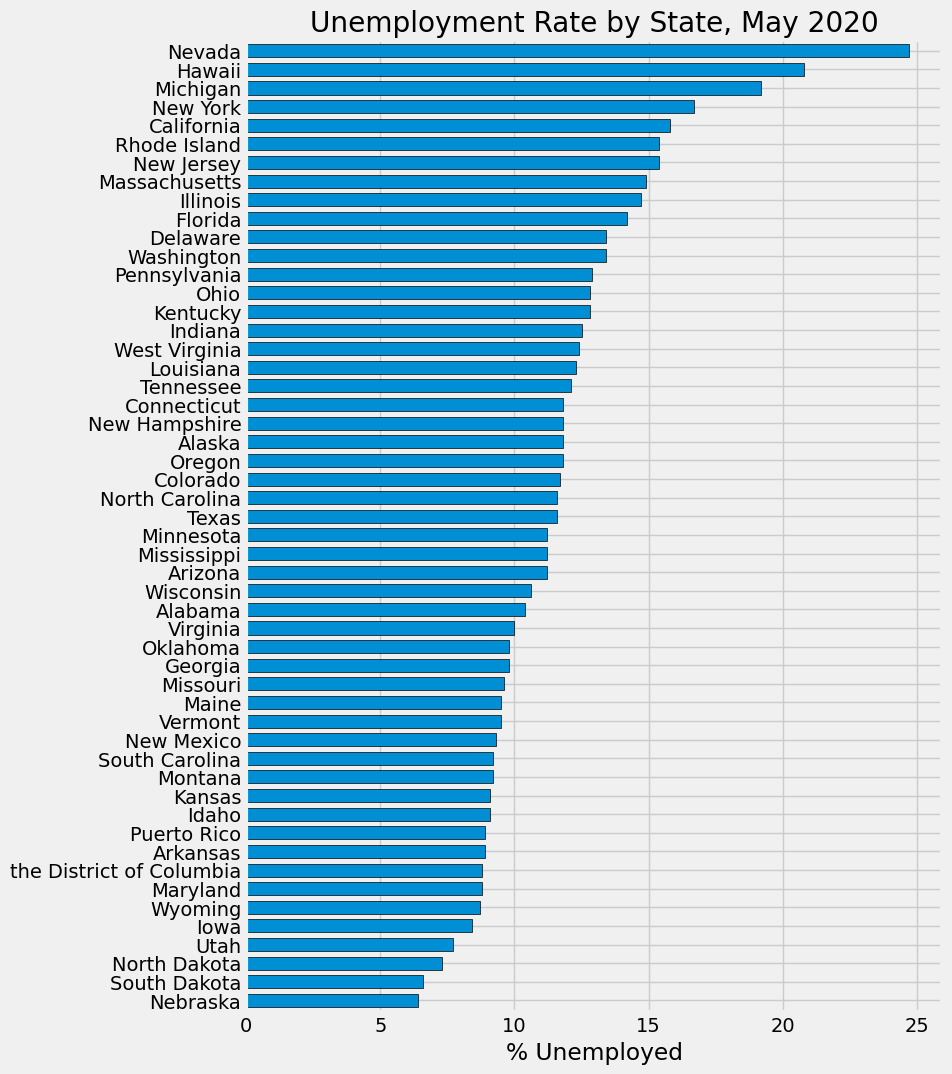

In [11]:
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

In [12]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [14]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(1)

part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

In [15]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

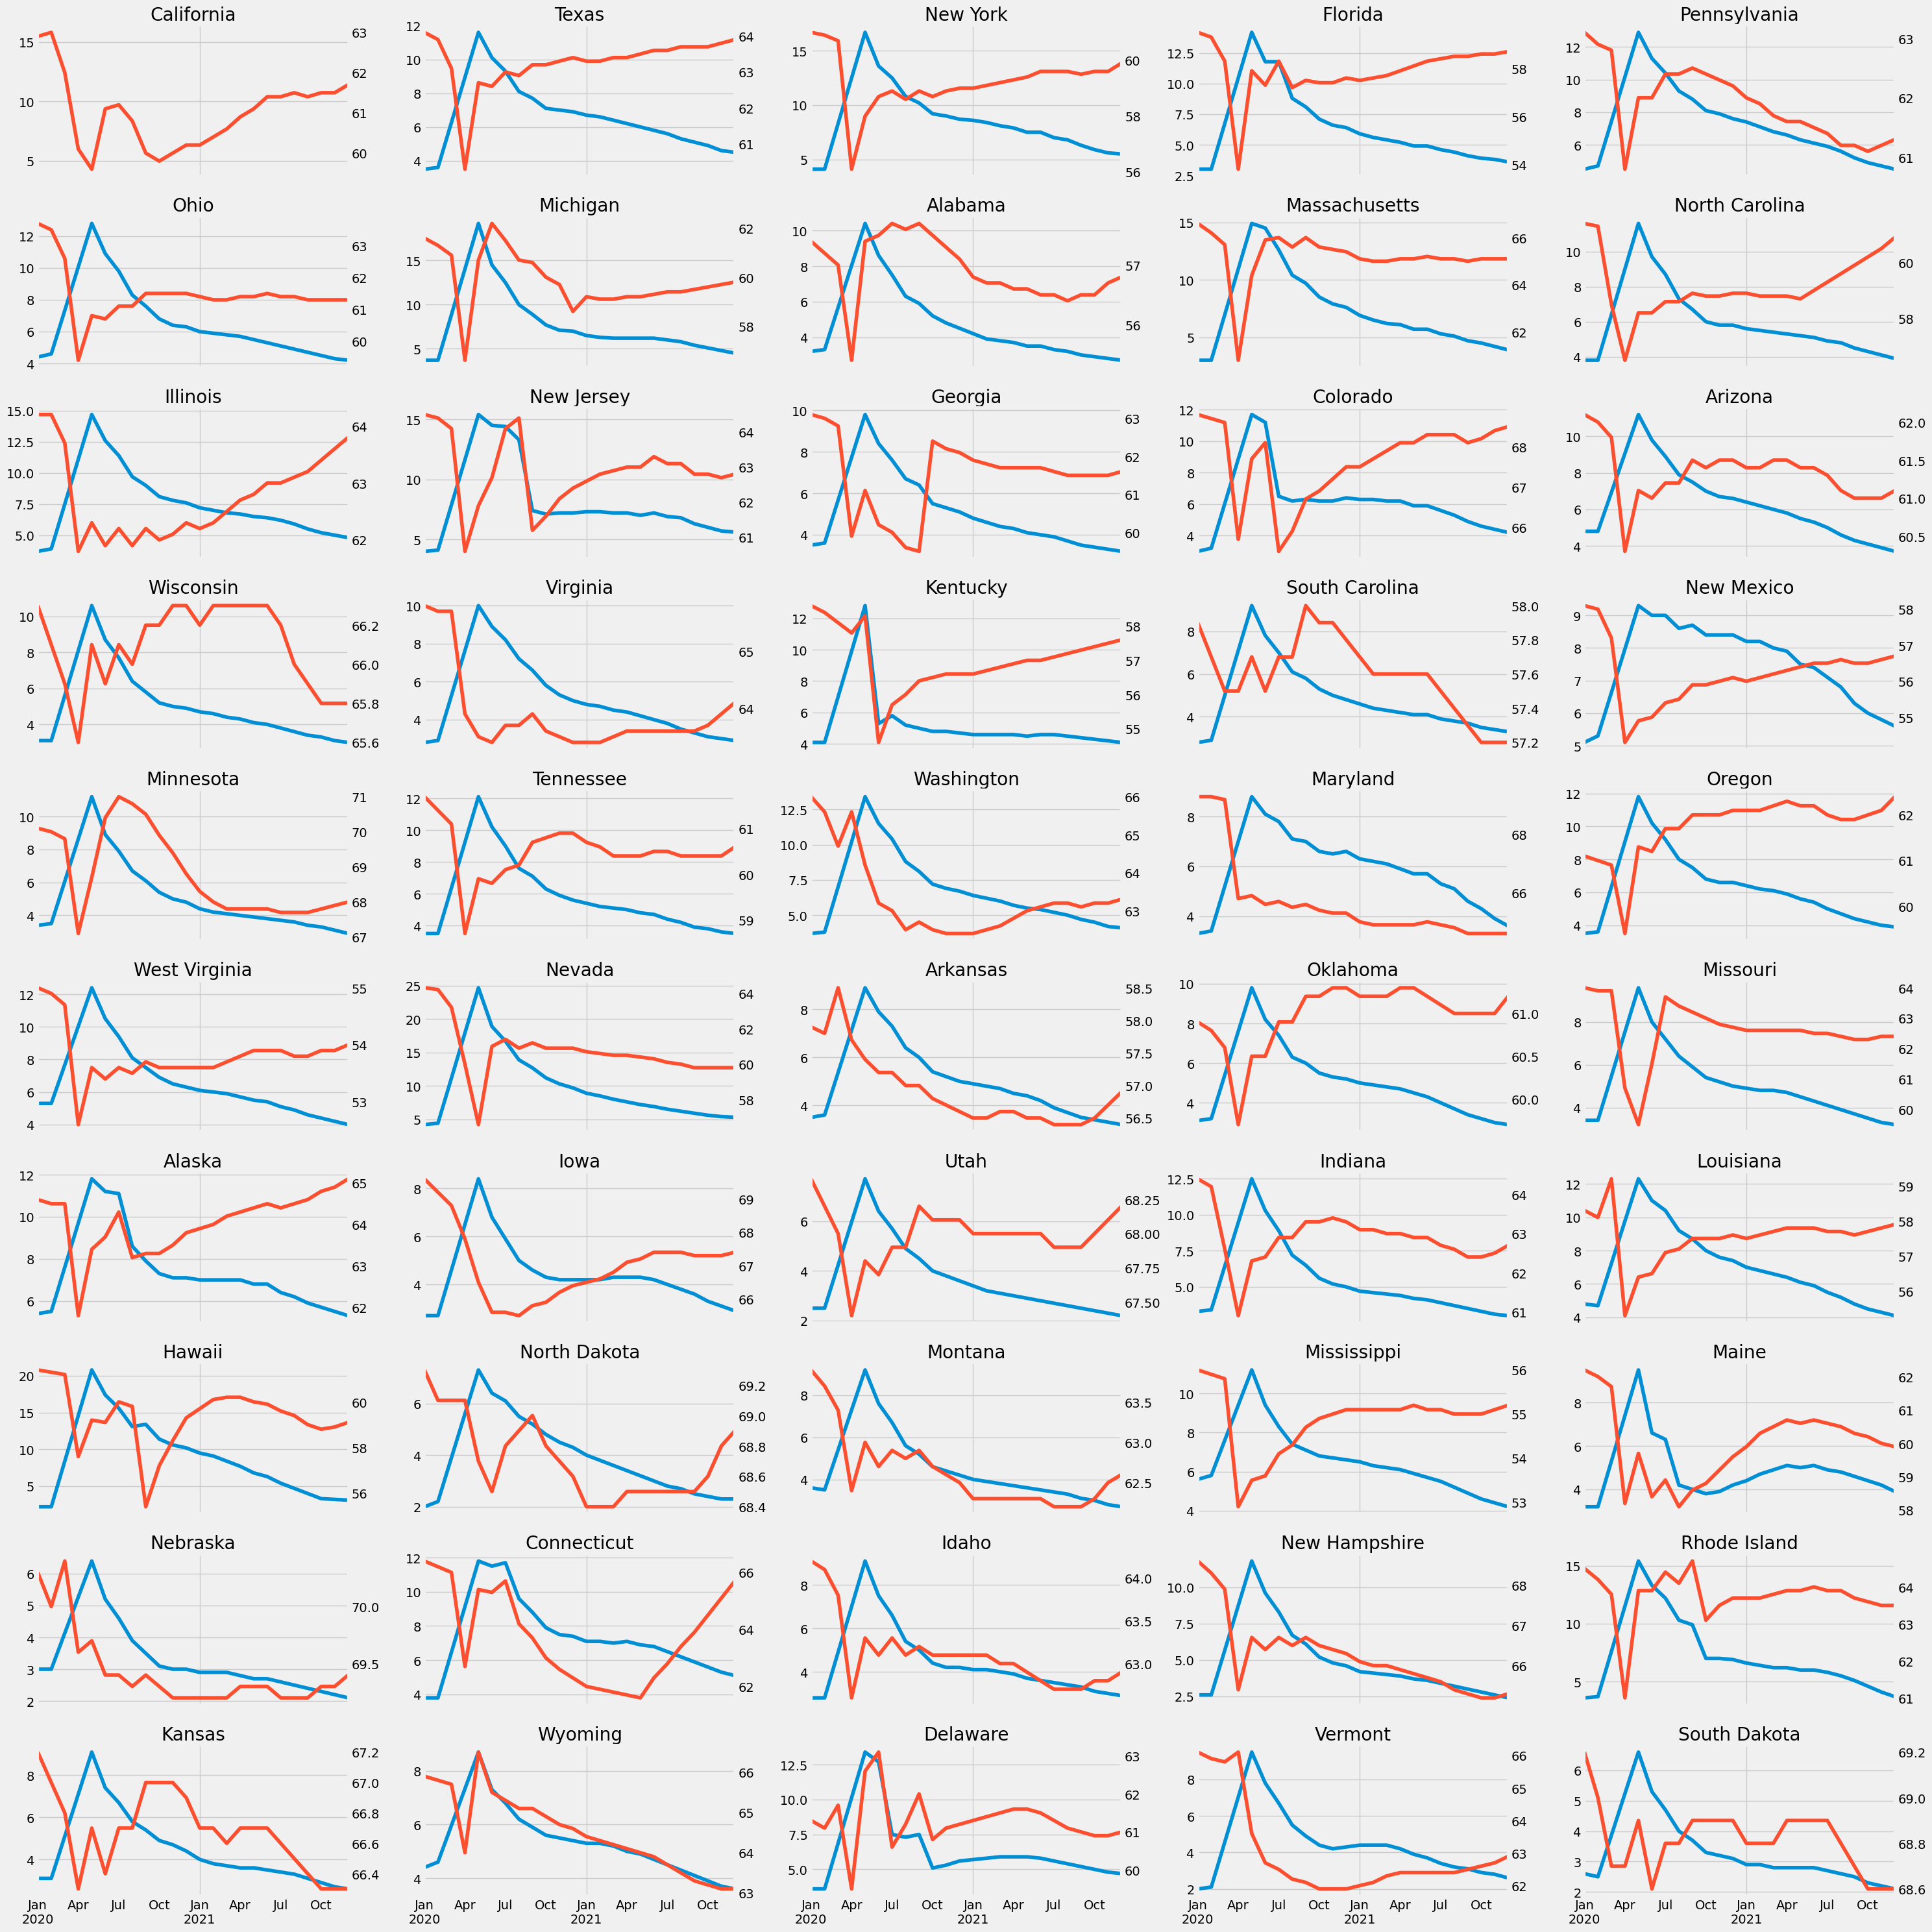

In [16]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()